In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import radians, sin, cos, sqrt, atan2

In [1516]:
user = pd.read_csv('./data/user.csv')
destination = pd.read_csv('./data/destinasi-wisata-indonesia.csv')
bali =  pd.read_csv('./data/Dataset - tourismBali.csv')

In [1517]:
user.head()

,User_Id,Location,Age
0,1,"Semarang, Jawa Tengah",20
1,2,"Bekasi, Jawa Barat",21
2,3,"Cirebon, Jawa Barat",23
3,4,"Bekasi, Jawa Barat",21
4,5,"Lampung, Sumatera Selatan",20


In [1518]:
bali.head()

,Place_Id,Place_Name,Description,Weekend Holiday Price,Weekday Price,Category,City,Rating,Alamat,Coordinate,Lat,Long,Gambar
0,1,Agrowisata Satria,Agrowisata Satria menawarkan 'rasa' Bali pada ...,50000,50000,Agrowisata,Gianyar,3.0,"Manukaya, Kec. Tampaksiring, Kabupaten Gianya...","-8.402228546131536, 115.32296693687739",-8.402229,115.322967,V
1,2,Agung Bali,Dapatkan berbagai produk oleh-oleh khas Bali b...,0,0,Belanja,Badung,4.0,"Jln. Dewi Sri No.18XX, Kuta, Badung, Bali","-8.700234336021559, 115.176534407375",-8.700234,115.176534,V
2,3,Wisata Air Panas Toya Bungkah,Pemandian air panas di dekat gunung Batur (Pem...,70000,70000,Alam,Bangli,4.0,"Batur Tengah, Kec. Kintamani, Kabupaten Bangli...","-8.251298580809106, 115.39981444195475",-8.251299,115.399814,V
3,4,Air Terjun Aling-Aling,Keberadaan air terjun ini semakin mempercantik...,20000,20000,Alam,Buleleng,4.5,"Jl. Raya Desa Sambangan, Banjar, Sambangan, Ke...","-8.173073590748519, 115.10513024047802",-8.173074,115.105130,V
4,5,Air Terjun Tegenungan,Bosan dengan wisata alam pantai dan ingin meni...,20000,20000,Alam,Gianyar,4.0,"Jl. Ir. Sutami, Kemenuh, Kec. Sukawati, Kabupa...","-8.575191460385602, 115.28870189592831",-8.575191,115.288702,V


In [1519]:
bali[['Weekday Price', 'Weekend Holiday Price']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype
---  ------                 --------------  -----
 0   Weekday Price          75 non-null     int64
 1   Weekend Holiday Price  75 non-null     int64
dtypes: int64(2)
memory usage: 1.3 KB


In [1520]:
mean = (bali['Weekday Price'].values + bali['Weekend Holiday Price'].values) / 2

In [1521]:
mean

array([ 50000.,      0.,  70000.,  20000.,  20000.,  15000., 300000.,
       102500.,  20000., 500000.,      0.,  32500.,  50000.,      0.,
        15000.,  30000.,  10000.,  10000.,      0.,      0.,      0.,
        95000.,  30000.,  25000.,  15000.,  10000.,      0.,  40000.,
            0.,      0.,  25000.,      0.,  60000.,  25000.,  25000.,
        10000.,  10000.,      0.,      0.,  10000.,  10000.,      0.,
            0.,   5000.,      0.,   8000.,      0.,   5000.,   8000.,
            0.,      0.,  10000.,      0.,      0.,      0.,      0.,
        30000.,  30000.,  10000.,  50000.,  15000.,      0.,  15000.,
        15000.,  30000.,  50000.,      0.,      0., 100000., 150000.,
        10000.,  25000., 289000.,  10000.,      0.])

In [1522]:
bali['Price'] = mean

In [1523]:
bali.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Weekend Holiday Price',
       'Weekday Price', 'Category', 'City', 'Rating', 'Alamat', 'Coordinate',
       'Lat', 'Long', 'Gambar', 'Price'],
      dtype='object')

In [1524]:
destination.columns

Index(['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price',
       'Rating', 'Time_Minutes', 'Coordinate', 'Lat', 'Long', 'Column1', '_1',
       'Rating_Count'],
      dtype='object')

In [1525]:
bali = bali[['Place_Id', 'Place_Name', 'Description', 'Category', 'City', 'Price', 'Rating', 'Coordinate', 'Lat', 'Long']]

In [1526]:
bali['City'] = 'Bali'

In [1527]:
destination = pd.concat([destination, bali], ignore_index=True)

In [1528]:
destination.shape

(512, 14)

In [1529]:
destination.head()

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Column1,_1,Rating_Count
0,1,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,46.0,15.0,"{'lat': -6.1753924, 'lng': 106.8271528}",-61753924.0,1.068272e+09,NaN,1.0,18.0
1,2,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,46.0,90.0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-61376448.0,1.068171e+09,NaN,2.0,25.0
2,3,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,46.0,360.0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-61253124.0,1.068335e+09,NaN,3.0,19.0
3,4,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000.0,45.0,NaN,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-63024459.0,1.068952e+09,NaN,4.0,21.0
4,5,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,45.0,60.0,"{'lat': -6.12419, 'lng': 106.839134}",-612419.0,1.068391e+08,NaN,5.0,24.0


In [1530]:
destination['Rating'] =  (destination['Rating'] / destination['Rating_Count']).round(2)

In [1531]:
destination['Rating'].value_counts()

Rating
2.00    20
2.05    19
2.10    11
2.19    10
1.88    10
        ..
0.31     1
1.85     1
1.21     1
0.38     1
1.37     1
Name: count, Length: 125, dtype: int64

In [1532]:
destination['City'].value_counts()

City
Yogyakarta    126
Bandung       124
Jakarta        84
Bali           75
Semarang       57
Surabaya       46
Name: count, dtype: int64

In [1533]:
destination['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah', 'Agrowisata', 'Belanja',
       'Alam', 'Rekreasi', 'Religius', 'Pantai'], dtype=object)

In [1534]:
destination['Category'] = destination['Category'].replace('Pantai', 'Bahari')

In [1535]:
destination['Category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah', 'Agrowisata', 'Belanja',
       'Alam', 'Rekreasi', 'Religius'], dtype=object)

In [1536]:
destination[destination['Category'] == 'Bahari' ].sample(7)

,Place_Id,Place_Name,Description,Category,City,Price,Rating,Time_Minutes,Coordinate,Lat,Long,Column1,_1,Rating_Count
154,155,Pantai Ngobaran,Pantai Ngobaran merupakan salah satu tempat wi...,Bahari,Yogyakarta,5000.0,2.09,NaN,"{'lat': -8.1184844, 'lng': 110.5028785}",-81184844.0,1.105029e+09,NaN,155.0,22.0
125,126,Pantai Goa Cemara,Pantai Goa Cemara (bahasa Jawa: ꦥꦱꦶꦱꦶꦂ​ ꦒꦸꦮ​ ꦕ...,Bahari,Yogyakarta,4000.0,2.05,NaN,"{'lat': -7.999422999999998, 'lng': 110.248963}",-7999423.0,1.102490e+08,NaN,126.0,21.0
10,11,Pulau Bidadari,Pulau Bidadari merupakan salah satu resor di K...,Bahari,Jakarta,5000.0,1.92,NaN,"{'lat': -6.035832999999999, 'lng': 106.746944}",-6035833.0,1.067469e+08,NaN,11.0,24.0
155,156,Pantai Pulang Sawal,Pantai Pulang Sawal yang ada di Kecamatan Tepu...,Bahari,Yogyakarta,10000.0,1.61,NaN,"{'lat': -8.1506589, 'lng': 110.6126311}",-81506589.0,1.106126e+09,NaN,156.0,28.0
11,12,Pulau Pari,Pulau Pari adalah sebuah pulau yang terletak d...,Bahari,Jakarta,150000.0,0.27,NaN,"{'lat': -5.9074328, 'lng': 106.5863989}",-59074328.0,1.065864e+09,NaN,12.0,15.0
167,168,Pantai Timang,Pantai Timang adalah objek wisata berupa panta...,Bahari,Yogyakarta,10000.0,2.14,90.0,"{'lat': -8.1759266, 'lng': 110.6624196}",-81759266.0,1.106624e+09,NaN,168.0,22.0
342,343,Pantai Baruna,kunjungi Pantai Baruna yang berada di Kota Sem...,Bahari,Semarang,3000.0,0.15,NaN,"{'lat': -6.945105199999999, 'lng': 110.3982398}",-69451052.0,1.103982e+09,NaN,343.0,26.0


In [1537]:
destination.isnull().sum()

Place_Id          0
Place_Name        0
Description       0
Category          0
City              0
Price             0
Rating           75
Time_Minutes    307
Coordinate        0
Lat               0
Long              0
Column1         512
_1               75
Rating_Count     75
dtype: int64

In [1538]:
destination.drop(columns=['Place_Id','Time_Minutes', 'Column1', '_1'], inplace=True)

In [1539]:
destination.columns

Index(['Place_Name', 'Description', 'Category', 'City', 'Price', 'Rating',
       'Coordinate', 'Lat', 'Long', 'Rating_Count'],
      dtype='object')

In [1540]:
destination = destination.rename(columns={'Place_Name':'place_name',
                                          'Description':'description',
                                          'Category':'category',
                                          'City':'city',
                                          'Price':'price',
                                          'Rating':'rating_avg',
                                          'Rating_Count' : 'rating_count',
                                          'Lat': 'latitude', 
                                          'Long': 'longitude',
                                          'Coordinate':'coordinate'})

In [1541]:
destination[['rating_avg', 'rating_count']] = 0

In [1542]:
destination.duplicated().sum()

0

In [1543]:
destination.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 512 entries, 0 to 511
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   place_name    512 non-null    object 
 1   description   512 non-null    object 
 2   category      512 non-null    object 
 3   city          512 non-null    object 
 4   price         512 non-null    float64
 5   rating_avg    512 non-null    int64  
 6   coordinate    512 non-null    object 
 7   latitude      512 non-null    float64
 8   longitude     512 non-null    float64
 9   rating_count  512 non-null    int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 40.1+ KB


##REKOMENDASI BY KATEGORI WISATA

### PREPROCESSING
di encode + cari kesamaan pake cosine similarity

In [1544]:
oneHotCategory = OneHotEncoder(sparse=False)

In [1545]:
categoryEncoded = oneHotCategory.fit_transform(destination[['category']])

c:\Users\Akmal Fauzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [1546]:
categoryEncoded = pd.DataFrame(categoryEncoded, columns=oneHotCategory.get_feature_names_out(['category']))

In [1547]:
categoryEncoded

,category_Agrowisata,category_Alam,category_Bahari,category_Belanja,category_Budaya,category_Cagar Alam,category_Pusat Perbelanjaan,category_Rekreasi,category_Religius,category_Taman Hiburan,category_Tempat Ibadah
0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
507,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
510,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1548]:
cosineSim = cosine_similarity(categoryEncoded)

In [1549]:
cosineSim = pd.DataFrame(cosine_similarity(categoryEncoded), index=destination.index, columns=destination.index)

In [1550]:
cosineSim

,0,1,2,3,4,5,6,7,8,9,...,502,503,504,505,506,507,508,509,510,511
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
507,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
508,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
510,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0


### Content-Based

In [1551]:
def getRecommendationsByCategory(selected_category, destination, cosineSim, top_n=5):
    # Cari indeks destinasi yang memiliki kategori sesuai dengan kategori yang dipilih
    category_indices = destination[destination['category'] == selected_category].index

    if category_indices.empty:
        print("Kategori yang dipilih tidak ditemukan dalam data destinasi.")
        return []

    recommendations = []

    for idx in category_indices:
        similarity_scores = cosineSim.loc[idx]
        sorted_scores = similarity_scores.sort_values(ascending=False).iloc[1:]
        
        recommended_indices = sorted_scores.head(top_n).index
        recommended_places = destination.loc[recommended_indices, ['place_name', 'category']]

        recommendations.extend(recommended_places.to_dict('records'))

    unique_recommendations = {rec['place_name']: rec['category'] for rec in recommendations}
    return list(unique_recommendations.items())

In [1552]:
recommendations = getRecommendationsByCategory("Bahari", destination, cosineSim, top_n=5)
print("Rekomendasi Berdasarkan Kategori Wisata:")
for place, category in recommendations:
    print(f"{place} - Kategori: {category}")

Rekomendasi Berdasarkan Kategori Wisata:
Pantai Jimbaran - Kategori: Bahari
Pantai Krakal - Kategori: Bahari
Pantai Sepanjang - Kategori: Bahari
Pantai Goa Cemara - Kategori: Bahari
Hutan Mangrove Kulon Progo - Kategori: Bahari


### Rekomendasi Terdekat

In [1553]:
destination['latitude'] = destination['latitude'].apply(lambda x: float(str(x).replace("'", "").replace("{", "").replace("}", "").split(':')[-1].strip()))
destination['longitude'] = destination['longitude'].apply(lambda x: float(str(x).replace("'", "").replace("{", "").replace("}", "").split(':')[-1].strip()))

In [1554]:
destination

,place_name,description,category,city,price,rating_avg,coordinate,latitude,longitude,rating_count
0,Monumen Nasional,Monumen Nasional atau yang populer disingkat d...,Budaya,Jakarta,20000.0,0,"{'lat': -6.1753924, 'lng': 106.8271528}",-6.175392e+07,1.068272e+09,0
1,Kota Tua,"Kota tua di Jakarta, yang juga bernama Kota Tu...",Budaya,Jakarta,0.0,0,"{'lat': -6.137644799999999, 'lng': 106.8171245}",-6.137645e+07,1.068171e+09,0
2,Dunia Fantasi,Dunia Fantasi atau disebut juga Dufan adalah t...,Taman Hiburan,Jakarta,270000.0,0,"{'lat': -6.125312399999999, 'lng': 106.8335377}",-6.125312e+07,1.068335e+09,0
3,Taman Mini Indonesia Indah (TMII),Taman Mini Indonesia Indah merupakan suatu kaw...,Taman Hiburan,Jakarta,10000.0,0,"{'lat': -6.302445899999999, 'lng': 106.8951559}",-6.302446e+07,1.068952e+09,0
4,Atlantis Water Adventure,Atlantis Water Adventure atau dikenal dengan A...,Taman Hiburan,Jakarta,94000.0,0,"{'lat': -6.12419, 'lng': 106.839134}",-6.124190e+05,1.068391e+08,0
...,...,...,...,...,...,...,...,...,...,...
507,Teras Sawah Tegalalang,"Uniknya Tegallalang Rice Terrace di Bali ini, ...",Agrowisata,Bali,10000.0,0,"-8.433891714602193, 115.27918179571854",-8.433892e+00,1.152792e+02,0
508,Tirta Gangga,Ada tiga hal utama yang ada di taman Tirta Gan...,Religius,Bali,25000.0,0,"-8.412071345387545, 115.58728116872855",-8.412071e+00,1.155873e+02,0
509,Waterbom Bali,Waterbom merupakan sebuah oase di jantung kawa...,Rekreasi,Bali,289000.0,0,"-8.72828817001415, 115.16934211106027",-8.728288e+00,1.151693e+02,0
510,Alas Harum Agro Tourism,Alas Harum Bali merupakan destinasi wisata yan...,Agrowisata,Bali,10000.0,0,"-8.43969896624251, 115.28060749756382",-8.439699e+00,1.152806e+02,0


In [1555]:
destination[['place_name', 'latitude', 'longitude']].sample(5)

,place_name,latitude,longitude
13,Pulau Pelangi,-5587055.0,1.065885e+06
204,Desa Wisata Tembi,-78725673.0,1.103547e+09
248,Upside Down World Bandung,-68963.0,1.076170e+05
58,Museum Sumpah Pemuda,-61838388.0,1.068431e+09
148,Goa Cerme,-79794413.0,1.103803e+09


In [1556]:
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  
    lat1 = radians(lat1)
    lon1 = radians(lon1)
    lat2 = radians(lat2)
    lon2 = radians(lon2)
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [1557]:
def getTempatTerdekat(user_lat, user_long, data, top_n=5):
    data['distance_km'] = data.apply(lambda row: haversine(user_lat, user_long, row['latitude'], row['longitude']), axis=1)
    nearest_places = data.sort_values(by='distance_km').head(top_n)
    return nearest_places

In [1558]:
user_lat, user_long = -7.802450e+07, 1.103640e+09

In [1559]:
nearest_places = getTempatTerdekat(user_lat, user_long, destination)

In [1560]:
nearest_places[['place_name', 'category', 'city', 'distance_km']]

,place_name,category,city,distance_km
436,Gereja Perawan Maria Tak Berdosa Surabaya,Tempat Ibadah,Surabaya,381.466329
213,Trans Studio Bandung,Taman Hiburan,Bandung,421.744835
354,Umbul Sidomukti,Cagar Alam,Semarang,431.730056
75,Taman Cattleya,Taman Hiburan,Jakarta,483.949566
74,SnowBay Waterpark,Taman Hiburan,Jakarta,543.701867


In [1561]:
destination.to_csv('./data/destinasiWisata.csv', index=False)

### Collaborative Filtering

In [1562]:
# review = pd.read_csv('./data/review.csv')
# bookmark = pd.read_csv('./data/bookmark.csv')
# likes = pd.read_csv('./data/likes.csv')

In [1563]:
n_users = 2000
n_items = 512

In [1564]:
# Data review dengan distribusi rating natural
np.random.seed(42)
review_data = pd.DataFrame({
    'user_id': np.random.randint(1, n_users + 1, 10000),
    'item_id': np.random.randint(1, n_items + 1, 10000),
    'rating': np.random.choice([1, 2, 3, 4, 5], size=10000, p=[0.05, 0.1, 0.25, 0.35, 0.25])
}).drop_duplicates(subset=['user_id', 'item_id'])

# Daftar popular items
popular_items = np.random.choice(range(1, n_items + 1), size=100, replace=False)

# Data bookmark
bookmark_data = pd.DataFrame({
    'user_id': np.random.randint(1, n_users + 1, 6000),
    'item_id': np.random.choice(popular_items, 6000),
})
bookmark_data['is_bookmarked'] = np.random.choice([0, 1], size=len(bookmark_data), p=[0.1, 0.9])

# Data like
like_data = pd.DataFrame({
    'user_id': np.random.randint(1, n_users + 1, 6000),
    'item_id': np.random.choice(popular_items, 6000),
})
like_data['is_liked'] = np.random.choice([0, 1], size=len(like_data), p=[0.2, 0.8])

In [1565]:
# Tambahkan kolom liked dan bookmarked di review_data berdasarkan rating
review_data['liked'] = (review_data['rating'] >= 4).astype(int)
review_data['bookmarked'] = (review_data['rating'] >= 4).astype(int)

In [1566]:
# Merge review_data dengan bookmark_data dan like_data
data = review_data.merge(bookmark_data, on=['user_id', 'item_id'], how='left')
data = data.merge(like_data, on=['user_id', 'item_id'], how='left')

In [1567]:
# Isi nilai NaN pada is_bookmarked dan is_liked dengan 0
data['is_bookmarked'] = data['is_bookmarked'].fillna(0).astype(int)
data['is_liked'] = data['is_liked'].fillna(0).astype(int)

In [1568]:
data.sample(12)

,user_id,item_id,rating,liked,bookmarked,is_bookmarked,is_liked
454,284,118,4,1,1,0,0
2918,1474,8,4,1,1,0,0
3051,915,271,3,0,0,0,0
7108,849,22,5,1,1,0,0
4129,1153,258,5,1,1,0,0
9870,1976,234,2,0,0,0,0
9934,525,15,4,1,1,0,0
3584,1993,480,3,0,0,0,0
3399,1598,387,3,0,0,0,0
2968,1588,185,3,0,0,0,0


In [1569]:
# Input untuk user_id dan item_id
user_input = Input(shape=(1,), name='user_input')
item_input = Input(shape=(1,), name='item_input')

In [1570]:
# Input untuk fitur tambahan (bookmark dan like)
bookmark_input = Input(shape=(1,), name='bookmark_input')
like_input = Input(shape=(1,), name='like_input')

In [1571]:
# Embedding untuk user dan item
user_embedding = Embedding(input_dim=n_users + 1, output_dim=10,
                            embeddings_regularizer=tf.keras.regularizers.l2(0.01))(user_input)
item_embedding = Embedding(input_dim=n_items + 1, output_dim=10, 
                            embeddings_regularizer=tf.keras.regularizers.l2(1e-4))(item_input)


In [1572]:
# Flatten embedding
user_vec = Flatten()(user_embedding)
item_vec = Flatten()(item_embedding)

In [1573]:
# Gabungkan embedding dan fitur tambahan
concat = Concatenate()([user_vec, item_vec, bookmark_input, like_input])

In [1574]:
# Dense layers untuk prediksi
dense = Dense(128, activation='relu')(concat)
dense = Dropout(0.5)(dense)
dense = Dense(64, activation='relu')(dense)
dense = Dense(32, activation='relu')(dense)
rating_output = Dense(1, activation='linear', name='rating_output')(dense)

In [1575]:
model = Model(inputs=[user_input, item_input, bookmark_input, like_input], outputs=rating_output)
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ item_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_28        │ (None, 1, 10)     │     20,010 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_29        │ (None, 1, 10)     │      5,130 │ item_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_32          │ (None, 10)        │          0 │ embedding_28[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_33          │ (None, 10)        │          0 │ embedding_29[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bookmark_input      │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ like_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 22)        │          0 │ flatten_32[0][0], │
│ (Concatenate)       │                   │            │ flatten_33[0][0], │
│                     │                   │            │ bookmark_input[0… │
│                     │                   │            │ like_input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 128)       │      2,944 │ concatenate_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_15          │ (None, 128)       │          0 │ dense_57[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_58 (Dense)    │ (None, 64)        │      8,256 │ dropout_15[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_59 (Dense)    │ (None, 32)        │      2,080 │ dense_58[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rating_output       │ (None, 1)         │         33 │ dense_59[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,453 (150.21 KB)

 Trainable params: 38,453 (150.21 KB)

 Non-trainable params: 0 (0.00 B)

In [1576]:
# Split data
train, test = train_test_split(data, test_size=0.2)

In [1577]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

In [1578]:
# Latih model
history = model.fit(
    [train['user_id'], train['item_id'], train['bookmarked'], train['liked']],
    train['rating'],
    validation_data=(
        [test['user_id'], test['item_id'], test['bookmarked'], test['liked']],
        test['rating']
    ),
    epochs=500,
    batch_size=64,
    callbacks=[early_stopping]
)

Epoch 1/500


c:\Users\Akmal Fauzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'item_input', 'bookmark_input', 'like_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6.2543 - val_loss: 0.3658
Epoch 2/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.5502 - val_loss: 0.4206
Epoch 3/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4637 - val_loss: 0.4903
Epoch 4/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4097 - val_loss: 0.6024
Epoch 5/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3791 - val_loss: 0.5495
Epoch 6/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3326 - val_loss: 0.6592
Epoch 7/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.3085 - val_loss: 0.5873
Epoch 8/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2960 - val_loss: 0.5689
Epoch 9/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2776 - val_loss: 0.5651
Epoch 10/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2743 - val_loss: 0.7020
Epoch 11/500
125/125 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.2619 - val_loss: 0.6209


In [1579]:
model.save('./models/colaborative.h5')

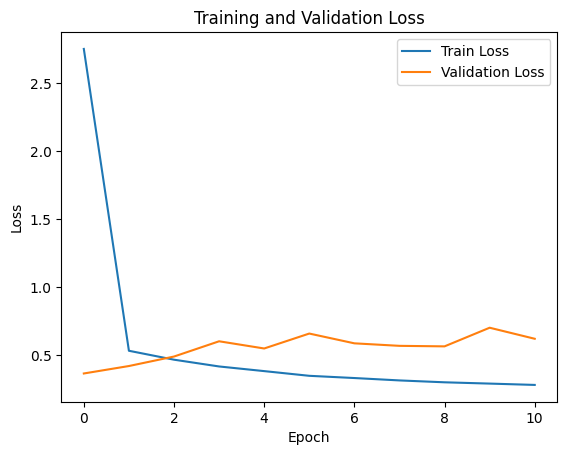

In [1580]:
# Plot loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [1581]:
# Prediksi
predictions = model.predict([test['user_id'], test['item_id'], test['bookmarked'], test['liked']])

# Hitung MSE dan RMSE
mse = mean_squared_error(test['rating'], predictions)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Mean Squared Error (MSE): 0.3490902367583022
Root Mean Squared Error (RMSE): 0.5908385877363649


In [1582]:
def recommend_hybrid(user_id, model, data, n_recommendations=5):
    # Ambil semua item yang mungkin
    item_ids = np.array(data['item_id'].unique())
    user_ids = np.array([user_id] * len(item_ids))
    bookmarked = np.zeros(len(item_ids))
    liked = np.zeros(len(item_ids))
    
    # Prediksi untuk semua item
    predicted_ratings = model.predict([user_ids, item_ids, bookmarked, liked]).flatten()
    
    # Ambil item dengan prediksi tertinggi
    top_items = item_ids[np.argsort(predicted_ratings)[-n_recommendations:]]
    return top_items

# Rekomendasi untuk user_id 2
recommended_items = recommend_hybrid(2, model, data)
print("Rekomendasi item untuk user_id 2:", recommended_items)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
Rekomendasi item untuk user_id 2: [438 332   4  42 470]


c:\Users\Akmal Fauzan\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['user_input', 'item_input', 'bookmark_input', 'like_input']. Received: the structure of inputs=('*', '*', '*', '*')
  warnings.warn(


In [1583]:
destination['category'].unique()

array(['Budaya', 'Taman Hiburan', 'Cagar Alam', 'Bahari',
       'Pusat Perbelanjaan', 'Tempat Ibadah', 'Agrowisata', 'Belanja',
       'Alam', 'Rekreasi', 'Religius'], dtype=object)